In [1]:
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [4]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

def get_data_labels(directory):
    # Create a list to store image paths and labels
    image_paths = []
    labels = []

    # Loop over the subdirectories (classes) in the given directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        
        # Only consider directories (not files)
        if os.path.isdir(class_path):
            # Loop over the images in each class directory
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):  # Convert to lowercase for consistency
                    # Add the image path and the corresponding class label
                    image_paths.append(os.path.join(class_path, filename))
                    labels.append(class_name)

    # Encoding the class labels into numeric values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    return np.array(image_paths), np.array(encoded_labels)

# Setting up file paths for training and testing (Fixed Path Issue)
USER_PATH = r"C:\Users\anisha\OneDrive\MINI PRO\DATASETS\archive (1)"
train_dir = os.path.join(USER_PATH, "Training")  # Corrected
test_dir = os.path.join(USER_PATH, "Testing")    # Corrected

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing training and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')

print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


x reshaped: (1, 224, 224, 3)


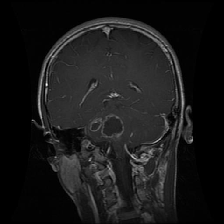

In [9]:
# Load an image from the dataset and resize it
im = load_img(train_paths[3], target_size=(224, 224))  # Change size if needed

# Convert to NumPy array
im = img_to_array(im)

# Add batch dimension for model input
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# Normalize pixel values (0 to 1)
im = im / 255.0

# Convert back to an image for visualization
im = array_to_img(im[0])
display(im)


In [10]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [13]:
# Data augmentation and preprocessing
# Global variables
SAVE = False
SEED = 111
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [14]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [17]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 20

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 20
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [19]:
# Define the model architecture
# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(N_TYPES, activation="softmax"))

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [23]:
# Define the model architecture
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

from tensorflow.keras.optimizers import Adam  # Import Adam correctly

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)  # Use Adam without legacy
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\anisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


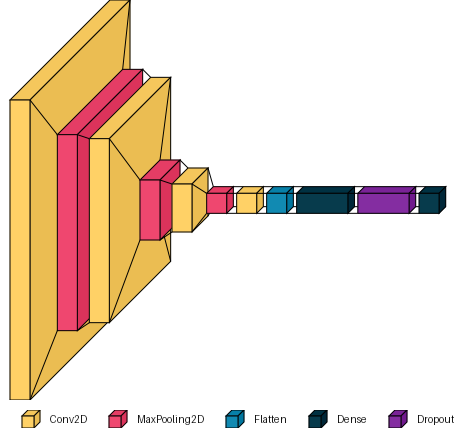

In [25]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)


In [28]:
# Apply Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,  # Train up to 20 epochs
    callbacks=[early_stopping]
)


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 412ms/step - accuracy: 0.9574 - loss: 0.1172 - val_accuracy: 0.9664 - val_loss: 0.1024
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 393ms/step - accuracy: 0.9682 - loss: 0.0913 - val_accuracy: 0.9451 - val_loss: 0.1813
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 312ms/step - accuracy: 0.9641 - loss: 0.1048 - val_accuracy: 0.9641 - val_loss: 0.0956
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 440ms/step - accuracy: 0.9701 - loss: 0.0856 - val_accuracy: 0.9733 - val_loss: 0.0788
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 506ms/step - accuracy: 0.9738 - loss: 0.0777 - val_accuracy: 0.9825 - val_loss: 0.0595
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 272ms/step - accuracy: 0.9755 - loss: 0.0738 - val_accuracy: 0.9710 - val_loss: 0.0807
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 282ms/step - accuracy: 0.9808 - loss: 0.0583 - val_accuracy: 0.9626 - val_loss: 0.1250
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 391ms/step - accuracy: 0.9768 - loss: 0

In [29]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9783 - loss: 0.0684
Test Loss: 0.06090
Test Accuracy: 0.98203


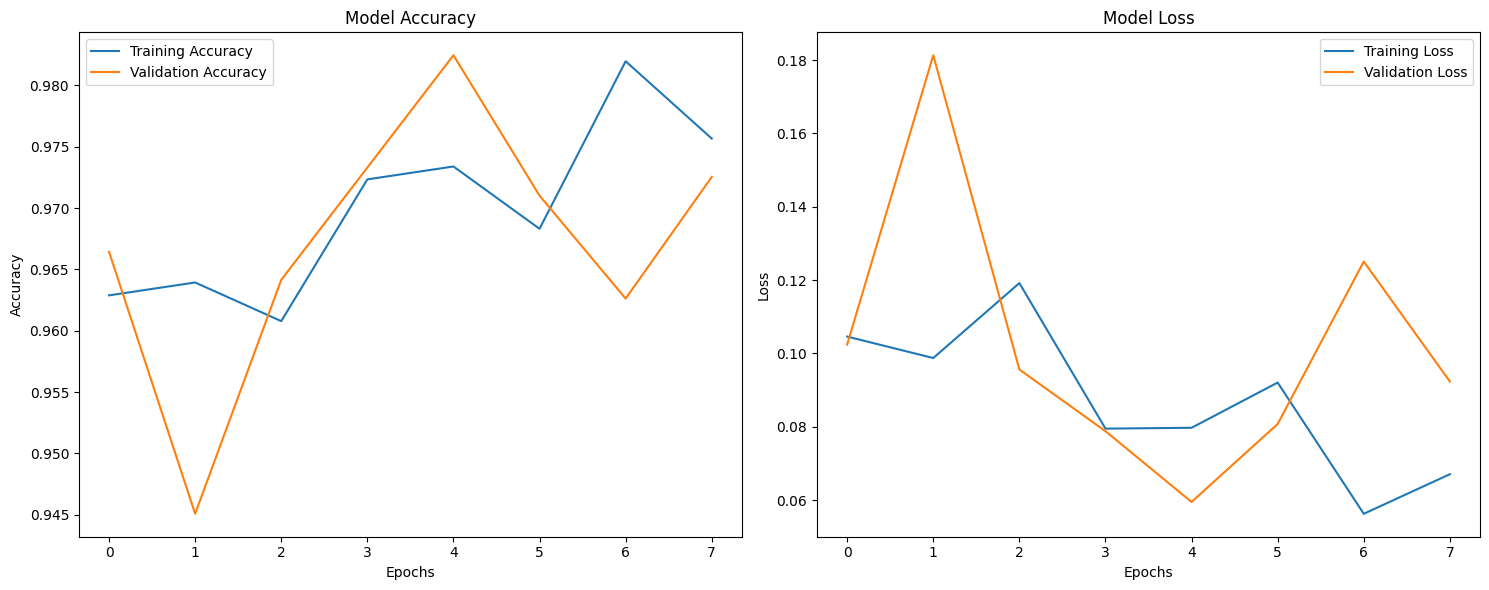

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot accuracy for the first subplot
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])

# Plot loss for the second subplot (optional, if you're also tracking loss)
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Training Loss', 'Validation Loss'])

# Display the plots
plt.tight_layout()
plt.show()

Class name of the first image: glioma
Shape (1, 150, 150, 3)


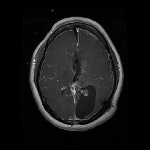

In [33]:
# Get the next batch from the test generator
batch_images, batch_labels = next(test_generator)

# Extract the first image from the batch
image, label = batch_images[0], batch_labels[0]
image_tensor = np.expand_dims(image, axis=0)

# Get the class indices from the test generator
class_indices = test_generator.class_indices

# Convert the one-hot encoded label to the class name
label_name = [k for k, v in class_indices.items() if np.argmax(label) == v][0]

# Display the class name
print(f"Class name of the first image: {label_name}")
print(f'Shape {image_tensor.shape}')
array_to_img(image_tensor[0])